In [ ]:
import os # Для работы с файлами
import requests # Запросы к удалённому серверу
import numpy as np # Для работы с данными 
import pandas as pd # Для работы с таблицами
import matplotlib.pyplot as plt # Для вывода графиков
%matplotlib inline

from tensorflow.keras.utils import plot_model, to_categorical  # Для визуализации модели и работы с категориальными данными 
from tensorflow.keras.models import load_model, Sequential # Полносвязная модель
from tensorflow.keras.layers import Dense, Dropout, SpatialDropout1D, BatchNormalization, Embedding, Flatten, Activation # Слои для сети
from tensorflow.keras.preprocessing.text import Tokenizer # Методы для работы с текстами и преобразования их в последовательности
from tensorflow.keras.preprocessing.sequence import pad_sequences # Метод для работы с последовательностями
from tensorflow.keras.optimizers import Adam, Adadelta # оптимизаторы
from tensorflow.keras.callbacks import ModelCheckpoint, Callback

from sklearn.preprocessing import LabelEncoder # Метод кодирования тестовых лейблов
from sklearn.model_selection import train_test_split # Для разделения выборки на тестовую и обучающую

from google.colab import drive, files # Для работы с файлами 

# Принцип работы

1. По vk api берём "жирного блогера" по нашей тематике с кучей друзей (в кругу общения у блогера есть, как правилоб друзья блогеры), составляем список друзей.

2. Проходим циклом по друзьям. Парсим данные.

3. Собираем датасет. На всякий случай - сохраняем датасет.

4. Отдаём датасет на предсказание модели. Обрабатываем сразу весь список. Получаем список вероятности классов. 

5. Если у интересующего нас класса вероятность выше порога - добавляем блогера в список для визуального контроля человеком. Если вероятность маленькая - вносим в список неактивных блогеров.

# Монтируем гугл-диск

In [ ]:
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Настройки
ВНИМАНИЕ! 
*   пропишите путь до вашей диретории;
*   укажите Ваш SERVICE_KEY для API vk.com;

In [ ]:
ROOT_PATH = '/content/drive/MyDrive/Colab Notebooks/ЦП 2021'  # ВНИМАНИЕ! Пропишите путь до вашей диретории
CLASS_LIST = ['Путешествия', 'История', 'Наука и техника' 'Развлечения', 'Новости', 'Политика', 'Бизнес', 'Спорт', 'Личные данные']
SERVICE_KEY = ''  # ВНИМАНИЕ! Укажите Ваш SERVICE_KEY для API vk.com
VERSION = '5.122'

# Парсер vk
1. Используя api vk.com получим индентификатор пользователя, по которому спарсим user_ids его друзей. Составм список [user_ids] его друзей

2. В цикле начинаем парсить данные его друзей.

2. Пройдём циклом по всем публикациям пользователя и склеим все текстовые поля в одно для дальнейшего создания "bag of words" ("мешка слов") для анализа текста.

3. В цикле возьмем 10 главных изображений публикации (если они есть) с разрешением от 200 до 400 пикселей по высоте. С большим количеством пикселей - нейросеть будет долго справляться и может быть ошибка из=за превышения лимита памяти. С меньшим разрешением - снизится качество распознавания, поэтому выберем изображения высотой от 200 до 400 пикселей из списка превьюшек в vk.com
Эти данные нужны будут для масштабирования проекта, когда пудем делать предсказания не только по тексту, но и по изображениям. На начальном этапе - только классификация по тексту.

4. Сформируем x_text датасет для нейронной сети.
Колонка 'user_id' - user_id пользователя, 'uid' => uid, 'text' - текст, 'img_0' ... 'img_9' - 10 ссылок на изображения

5. Отдадим датасет нейросети и получим список предсказаний.

6. Выведем список нужных блогеров

# Класс парсера Vk
Используем api vk для получения постов


In [ ]:
class User():
  def getId(self, user_ids):
    # Получаем id пользователя по user_ids
    data = {'access_token': SERVICE_KEY, 'v': VERSION, 'user_ids': user_ids}
    r = requests.get('https://api.vk.com/method/users.get', data)
    return r.json()['response'][0]['id']
  
  # Получаем все посты пользоватля
  def getWall(self, user_id):
    data = {'access_token': SERVICE_KEY, 'v': VERSION, 'owner_id': user_id}
    r = requests.get('https://api.vk.com/method/wall.get', data)
    r_json = r.json()
    if 'response' in r_json:  # Если профиль доступен
      return r_json['response']['items']
  
    return False  # Приватный профиль

  def getFriends(self, user_id):
    data = {'access_token': SERVICE_KEY, 'v': VERSION, 'user_id': user_id}
    r = requests.get('https://api.vk.com/method/friends.get', data)
    # print("\n\n--- Друзъя ---")
    # print(r.json())
    return r.json()['response']['items']

  # Получаем список с текстом и url изображениями для датасета
  def getDataList(self, posts):
    text = ''
    img_count = 0;
    img_list = []  # Список изображений
    for post in posts:
      text += post['text'] + ' '  # Получаем текст всех записей
      if img_count < 10:  # Возьмём только 10 последних изображений
        if 'attachments' in post:
          if post['attachments'][0]['type'] == 'photo':
            sizes = post['attachments'][0]['photo']['sizes']  # Список изображений, размеры, url
            for size in sizes:  # Перебираем размеры изображений
              if size['height'] > 200 and size['height'] < 400:
                img_list.append(size['url'])
                img_count += 1

    result_list = [text]

    # Возвращаем только данные, если текст длинее 100 символов и длина result_list == 11 (количество изображений = 10)
    if len(result_list[0]) > 100: # Пока только текст # and len(result_list) == 11:
      return result_list
    
    # Иначе данные считаем фальшивыми
    return False



# Cтартовый, "жирный" блогер



In [ ]:
bloger_start = 'drohn'

# Получаем список друзей блогера

In [ ]:
friend_list = []
user = User()
user_id = user.getId(bloger_start)
friends_ids_list = user.getFriends(user_id)

print(friends_ids_list)

[24113, 27630, 69240, 139259, 164931, 227770, 242724, 244561, 251551, 281896, 319802, 325425, 329936, 358927, 359125, 374393, 400643, 419558, 471000, 471640, 549529, 567877, 615493, 621794, 622702, 626556, 632499, 660564, 673099, 673380, 685054, 698276, 717905, 751188, 761707, 772754, 777032, 798518, 815429, 833623, 837464, 843529, 885611, 909611, 922174, 923827, 932682, 957710, 1003782, 1026953, 1071656, 1106104, 1130207, 1135758, 1189069, 1204452, 1239581, 1315708, 1350317, 1387919, 1409468, 1445702, 1465729, 1545405, 1562242, 1625845, 1670225, 1672586, 1694304, 1696153, 1719293, 1737134, 1794752, 1813134, 1818016, 1921759, 1981719, 2060563, 2081453, 2112115, 2117040, 2168399, 2168626, 2198802, 2262855, 2316878, 2385217, 2390249, 2420606, 2437417, 2520576, 2549717, 2582451, 2584778, 2586617, 2645685, 2730496, 2761849, 2770374, 2845803, 2877424, 2948084, 2955796, 2981746, 2992646, 3017303, 3042026, 3043213, 3053622, 3128115, 3169472, 3178848, 3190913, 3216156, 3243270, 3248966, 326496

# Перебираем список блогеров и создаём датасет, сохраняем

In [ ]:
user = User()
df_list = []  # Список для формирования датафрейма
friend_id_list = []  # Список id друзей
i = 1
for friend_id in friends_ids_list:
  if i > 100:  # У api vk есть ограничения. Что бы не попасть на фильтр - ограничем данные 100 пользователями.
    break

  posts = user.getWall(friend_id)  # Получаем идентификатор пользователя, если введён никнейм
  if not posts:  # Пропускаем приватные профили и те из которых мы не можем получить информацию
    continue

  data_list = user.getDataList(posts)
  if data_list:
    df_list.append(data_list)
    friend_id_list.append(friend_id)
    print(f'{i}, user_id: {friend_id}')  # Выводим номер и id пользователя
    i += 1

test_df = pd.DataFrame(df_list, columns=['text'])

test_df.to_csv(os.path.join(ROOT_PATH, 'vk_test_data.csv'), index=False)

1, user_id: 139259
2, user_id: 164931
3, user_id: 227770
4, user_id: 251551
5, user_id: 319802
6, user_id: 374393
7, user_id: 400643
8, user_id: 471000
9, user_id: 549529
10, user_id: 567877
11, user_id: 615493
12, user_id: 622702
13, user_id: 632499
14, user_id: 660564
15, user_id: 673099
16, user_id: 673380
17, user_id: 685054
18, user_id: 751188
19, user_id: 761707
20, user_id: 815429
21, user_id: 833623
22, user_id: 837464
23, user_id: 843529
24, user_id: 885611
25, user_id: 922174
26, user_id: 923827
27, user_id: 957710
28, user_id: 1003782
29, user_id: 1026953
30, user_id: 1106104
31, user_id: 1135758
32, user_id: 1239581
33, user_id: 1315708
34, user_id: 1350317
35, user_id: 1409468
36, user_id: 1545405
37, user_id: 1562242
38, user_id: 1670225
39, user_id: 1672586
40, user_id: 1694304
41, user_id: 1719293
42, user_id: 1737134
43, user_id: 1813134
44, user_id: 1818016
45, user_id: 2060563
46, user_id: 2112115
47, user_id: 2117040
48, user_id: 2168626
49, user_id: 2390249
50, use

# Посмотрим датафрейм

In [ ]:
print(f'Форма датасета:{test_df.shape}')
print('Посмотрим структуру датасета:\n', test_df.head())

Форма датасета:(100, 1)
Посмотрим структуру датасета:
                                                 text
0  Удивительно, насколько быстро отмирают наличны...
1  Недавно я выступил на стриме из вегетарианског...
2  Большая Удина - любимый вулкан на маршруте вок...
3  Если вы добавляетесь в друзья и знаете меня ли...
4    В апреле купила два деревянных пазла. Кита с...


# Гистограма длинны текста блогеров

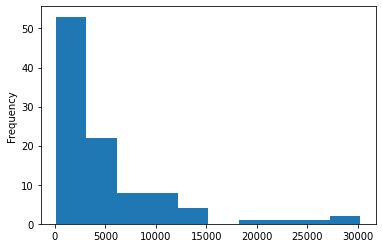

In [ ]:
text_len = test_df['text'].apply(len)
text_len.plot.hist()

In [ ]:
x_test = test_df['text'].to_numpy()

# Загрузка x_train датасета

In [ ]:
train_df = pd.read_csv(os.path.join(ROOT_PATH, 'vk_train_data.csv'))
print(f'Форма датасета:{train_df.shape}')
print('Посмотрим структуру датасета:\n', train_df.head())

Форма датасета:(105, 2)
Посмотрим структуру датасета:
                                                 text  y
0   В сумке у папы Моя татуха      Мой личный рей...  8
1  Ребятки, мы вместе Cheetos, Аней и Махой запус...  3
2  Онлайн-совещание по итогам работы в Беломорско...  4
3    Встретимся сегодня! Выкладывай свои записи с...  3
4  Ээээй бро!\nБудущего не знаем, но чтобы не был...  8


# Переводим в массив numpy и создаём x_train

In [ ]:
x_train = train_df['text'].to_numpy()
y = train_df['y'].to_numpy()

y_train = to_categorical(y)

print(f'Формы массивов x_train: {x_train.shape}, y_train: {y_train.shape}')

Формы массивов x_train: (105,), y_train: (105, 9)


# Токенизация
Используем токенизацию на 5 000 слов.

In [ ]:
num_words = 5000

tokenizer = Tokenizer(
    num_words=num_words,
    filters='!"#$%&*+,-–—./…;<=>?@[\\]^_`{|}~«»\t\n\xa0\ufeff',
    lower=True, 
    split=' ', 
    char_level=False, 
    oov_token='unknown'
)

tokenizer.fit_on_texts(x_train)
items = list(tokenizer.word_index.items())

m_train = tokenizer.texts_to_matrix(x_train)

print('Форма матрицы m_train:', m_train.shape, m_train[0])
print('Форма матрицы и элементы y_train:', y_train.shape, '\n', y_train[0])

Форма матрицы m_train: (105, 5000) [0. 1. 1. ... 0. 0. 0.]
Форма матрицы и элементы y_train: (105, 9) 
 [0. 0. 0. 0. 0. 0. 0. 0. 1.]


In [ ]:
m_test = tokenizer.texts_to_matrix(x_test)

print('Форма матрицы m_test:', m_test.shape, m_test[0])

Форма матрицы m_test: (100, 5000) [0. 1. 1. ... 0. 0. 0.]


# Загружаем модель

In [ ]:
model = load_model(os.path.join(ROOT_PATH, 'model.h5'))

# Предсказание

In [ ]:
predict = model.predict(m_test)


class_index_list = np.argmax(predict, axis=1)
print(class_index_list)

[8 3 0 6 8 3 0 3 6 0 0 3 8 3 8 0 0 6 3 3 3 3 3 3 3 0 3 0 3 3 0 3 8 0 4 3 8
 6 6 6 3 8 6 3 3 0 0 8 3 5 3 3 8 0 8 8 3 0 0 8 7 8 3 0 0 3 0 3 3 0 8 0 0 6
 3 0 0 3 0 0 0 0 0 8 0 3 8 8 0 3 8 0 8 6 8 3 0 0 8 3]


# Посмотрим на результат

In [ ]:
for i in range(len(class_index_list)):
  if class_index_list[i] == 0:  # Выбор категории "Путешествия"
    print(f'ПУТЕШЕСТВИЯ, https://vk.com/id{friend_id_list[i]}')
  if class_index_list[i] == 1:  # Выбор категории "История"
    print(f'ИСТОРИЯ, https://vk.com/id{friend_id_list[i]}')

ПУТЕШЕСТВИЯ, https://vk.com/id227770
ПУТЕШЕСТВИЯ, https://vk.com/id400643
ПУТЕШЕСТВИЯ, https://vk.com/id567877
ПУТЕШЕСТВИЯ, https://vk.com/id615493
ПУТЕШЕСТВИЯ, https://vk.com/id673380
ПУТЕШЕСТВИЯ, https://vk.com/id685054
ПУТЕШЕСТВИЯ, https://vk.com/id923827
ПУТЕШЕСТВИЯ, https://vk.com/id1003782
ПУТЕШЕСТВИЯ, https://vk.com/id1135758
ПУТЕШЕСТВИЯ, https://vk.com/id1350317
ПУТЕШЕСТВИЯ, https://vk.com/id2112115
ПУТЕШЕСТВИЯ, https://vk.com/id2117040
ПУТЕШЕСТВИЯ, https://vk.com/id2645685
ПУТЕШЕСТВИЯ, https://vk.com/id3042026
ПУТЕШЕСТВИЯ, https://vk.com/id3043213
ПУТЕШЕСТВИЯ, https://vk.com/id3264961
ПУТЕШЕСТВИЯ, https://vk.com/id3281671
ПУТЕШЕСТВИЯ, https://vk.com/id3431493
ПУТЕШЕСТВИЯ, https://vk.com/id3591244
ПУТЕШЕСТВИЯ, https://vk.com/id3623978
ПУТЕШЕСТВИЯ, https://vk.com/id3675837
ПУТЕШЕСТВИЯ, https://vk.com/id3884603
ПУТЕШЕСТВИЯ, https://vk.com/id4000893
ПУТЕШЕСТВИЯ, https://vk.com/id4060184
ПУТЕШЕСТВИЯ, https://vk.com/id4098590
ПУТЕШЕСТВИЯ, https://vk.com/id4119846
ПУТЕШЕСТВИЯ, https:

# При столь слабой обучающей выбоке (122 размеченых блогеров) мы получили столь потрясающий результат! УРА!!!!!!!!!!!!!!!!

У нас ещё есть огромный потенциал роста.